In [4]:
#!pip install -r requirements.txt

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from matplotlib import pyplot
import recmetrics
import sys
import pprint
import tqdm


from prediction import LtrPrediction
from processing import DataPreprocessing
import ltr_utils as ut

## Data Sampling

In [6]:
dv_train = pd.read_csv('recsys_data/train.csv')
x = dv_train[dv_train['response'] == 1].groupby('ip').size().reset_index(name='num_clicks').sort_values(by=['num_clicks'], ascending=False)['ip'].head(100)
df_ip = pd.DataFrame({'ip':x})
dv_train = pd.merge(dv_train,df_ip,on='ip')

In [7]:
dv_train.nunique()

ip            100
event_date     10
tcm_id         66
response        2
dtype: int64

In [8]:
len(dv_train)

8090

In [9]:
dv_test = pd.read_csv('recsys_data/test_all.csv')
dv_test = pd.merge(dv_test,df_ip,on='ip')

In [10]:
dv_test = dv_test.drop(['Unnamed: 0'], axis=1)
dv_test.nunique()

ip            100
event_date      1
tcm_id         66
response        2
dtype: int64

In [11]:
len(dv_test)

6600

In [12]:
dv_test = dv_test.head(1000)
dv_train = dv_train.head(1000)

In [13]:
dv_train.to_csv('outputs/sample_train.csv')
dv_test.to_csv('outputs/sample_test.csv')

## Data Preprocessing

In [14]:
data_dict = {
    'train' : 'outputs/sample_train.csv',
    'test' : 'outputs/sample_test.csv',
    'articles' : 'recsys_data/articles.csv',
    'users' : 'recsys_data/users.csv'
}

In [15]:
DataPrep = DataPreprocessing(data_dict)

(788, 19) (869, 19)


In [16]:
DataPrep.init_KG('outputs/KGs/KG_dep_parsing_100terms.txt')

In [17]:
DataPrep.init_SentenceTransformer('all-MiniLM-L6-v2')

In [18]:
train_data_df, test_data_df = DataPrep.fit_data_pipeline()

100%|██████████| 869/869 [00:06<00:00, 141.90it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 788/788 [00:05<00:00, 135.26it/s]


In [19]:
processed_data_dict = DataPrep.get_train_test_split(['art','usr','kg','st'])

(869, 151) (869, 1) (788, 151) (788, 1)


In [20]:
X_train, y_train, groups_train, qid_train, X_test, y_test, qid_test, groups_test = processed_data_dict['train_test']
test_data = processed_data_dict['test_data']

## Model Training

In [21]:
xgb_params = {  'booster':"gbtree", 
                'objective':"rank:pairwise",
                'tree_method':"gpu_hist", 
                'sampling_method':"gradient_based",
                'eval_metric':['map@10'],
             }

model = xgb.XGBRanker(**xgb_params)


model.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[groups_train,groups_test],  verbose=False)

result = model.evals_result()
train_score = np.mean(result['validation_0']['map@10'])
test_score = np.mean(result['validation_1']['map@10'])
print('default Train :  ', train_score)
print('default Test  :  ', test_score)

default Train :   0.7064806120303149
default Test  :   0.12259816035210382


## Hyperparameter Tuning

In [22]:
def objective(trial):

        metric = "map@10"

        tuning_params = {
                    "max_depth": trial.suggest_int("max_depth", 2, 8, step=1),
                    "subsample": trial.suggest_float("subsample", 0.5, 0.8, step=0.05),
                    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.05),
                    "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10.0, step=0.01),
                    "alpha": trial.suggest_float("alpha", 1e-8, 1.0),
                    "min_child_weight": trial.suggest_float("min_child_weight", 0.01, 10.0, step=0.01),
                    "gamma": trial.suggest_float("gamma", 0.01, 10.0, step=0.01),
                    "max_delta_step":  trial.suggest_float("max_delta_step", 0.01, 10.0, step=0.01),
                    "eta": trial.suggest_float("eta", 0.001, 10.0, step=0.001)

                }
        
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-map@10")

        model = xgb.XGBRanker(booster="gbtree", objective="rank:pairwise",
                            tree_method="gpu_hist", sampling_method="gradient_based",
                            eval_metric=metric,
                            verbosity=1,
                            n_estimators=5000,
                            early_stopping_rounds = 100, 
                            callbacks=[pruning_callback],
                            **tuning_params)

        model.fit(X_train, y_train, group=groups_train, eval_set=[(X_test, y_test)], eval_group=[groups_test],   verbose=False)

        result = model.evals_result()
        opt_score1 = np.mean(result['validation_0'][metric])

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return opt_score1

# optuna.logging.WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

pruner = optuna.pruners.MedianPruner(n_warmup_steps=20)
study = optuna.create_study(pruner=pruner, direction='maximize')
study.optimize(objective, n_trials=50)

In [23]:
print(f"Optimized MAP: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized MAP: 0.1647
Best params:
	max_depth: 7
	subsample: 0.75
	colsample_bytree: 0.65
	reg_lambda: 8.85
	alpha: 0.1547154892783072
	min_child_weight: 2.02
	gamma: 2.17
	max_delta_step: 4.22
	eta: 0.739


In [24]:
metric = "map@10"

model_bst = xgb.XGBRanker(booster="gbtree", objective="rank:pairwise",
                        tree_method="gpu_hist", sampling_method="gradient_based",
                        eval_metric=metric,
                        n_estimators=5000,
                        early_stopping_rounds = 50, 
                        verbosity=0,
                        **study.best_params)

model_bst.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[groups_train,groups_test],  verbose=False)
result = model_bst.evals_result()
train_score = np.max(result['validation_0']['map@10'])
test_score = np.max(result['validation_1']['map@10'])
print('Optimized Train :  ', train_score)
print('Optimized Test  :  ', test_score)

Optimized Train :   0.6016643380725071
Optimized Test  :   0.1545225103930461


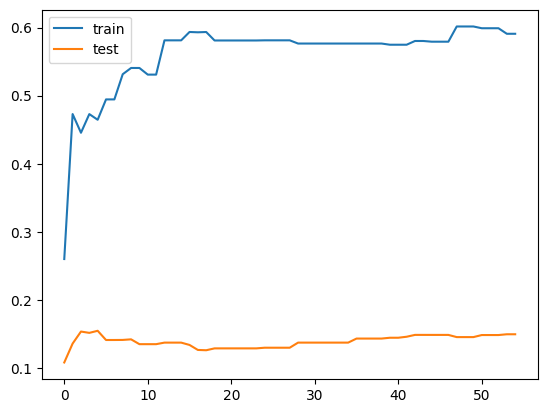

In [25]:
# plot learning curves
pyplot.plot(result['validation_0']['map@10'], label='train')
pyplot.plot(result['validation_1']['map@10'], label='test')
# show the legend
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (10,5)
# show the plot
pyplot.show()

## Model Evaluation

In [26]:
xgb_Prediction = LtrPrediction(model_bst, test_data)

In [27]:
results = xgb_Prediction.evaluate()
results

{'MAP@10': 0.09815734441924917,
 'Prediction_Coverage': 21.15,
 'Catalog_Coverage': 21.15,
 'Novelty': 0.0744875235131852,
 'personalization': 0.06285714285714272}

In [28]:
top_k_best_score_ips = xgb_Prediction.get_recomendation()

In [29]:
tcm_le = DataPrep.return_inverse_transform()
top_k_best_score_ips['article_actual_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_actual']) ,axis=1)
top_k_best_score_ips['article_recomended_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_prediction']) ,axis=1)

In [30]:
pd.set_option('max_columns', None)
pd.set_option('display.max_colwidth', None)
top_k_best_score_ips[['article_actual_ids','article_recomended_ids','apk']].sort_values(by='apk',ascending = False).head(10)

,article_actual_ids,article_recomended_ids,apk
ip,,,
395075,"[tcm:526-12167, tcm:526-674187, tcm:526-149043, tcm:526-16645, tcm:526-18025, tcm:526-209028, tcm:526-261006, tcm:526-273898, tcm:526-276414]","[tcm:526-261006, tcm:526-16645, tcm:526-149043, tcm:526-259315, tcm:526-40469, tcm:526-653510, tcm:526-80807, tcm:526-13782, tcm:526-187302, tcm:526-273898]",0.377778
1356756,"[tcm:526-13782, tcm:526-16645, tcm:526-684643, tcm:526-199040, tcm:526-231792, tcm:526-80807, tcm:526-40469]","[tcm:526-261006, tcm:526-16645, tcm:526-273898, tcm:526-259315, tcm:526-40469, tcm:526-653510, tcm:526-80807, tcm:526-13782, tcm:526-224772, tcm:526-149043]",0.261224
1602525,"[tcm:526-116442, tcm:526-16645, tcm:526-187302, tcm:526-209028, tcm:526-224772, tcm:526-249037, tcm:526-40469, tcm:526-46242]","[tcm:526-261006, tcm:526-16645, tcm:526-149043, tcm:526-259315, tcm:526-40469, tcm:526-653510, tcm:526-80807, tcm:526-13782, tcm:526-224772, tcm:526-187302]",0.204167
781367,"[tcm:526-116442, tcm:526-16645, tcm:526-199040, tcm:526-208086, tcm:526-695181, tcm:526-259315]","[tcm:526-261006, tcm:526-16645, tcm:526-149043, tcm:526-273898, tcm:526-259315, tcm:526-40469, tcm:526-653510, tcm:526-80807, tcm:526-13782, tcm:526-224772]",0.150000
1398529,"[tcm:526-16645, tcm:526-684643, tcm:526-199040, tcm:526-224772, tcm:526-22867, tcm:526-784445, tcm:526-80807]","[tcm:526-261006, tcm:526-273898, tcm:526-16645, tcm:526-149043, tcm:526-259315, tcm:526-40469, tcm:526-653510, tcm:526-80807, tcm:526-13782, tcm:526-224772]",0.126190
60747,"[tcm:526-551763, tcm:526-12174, tcm:526-681575, tcm:526-149043, tcm:526-18025, tcm:526-682576, tcm:526-93195, tcm:526-259315, tcm:526-276414]","[tcm:526-261006, tcm:526-16645, tcm:526-149043, tcm:526-259315, tcm:526-40469, tcm:526-653510, tcm:526-80807, tcm:526-13782, tcm:526-224772, tcm:526-187302]",0.092593
503477,"[tcm:526-656536, tcm:526-12180, tcm:526-674187, tcm:526-681575, tcm:526-16645, tcm:526-208086, tcm:526-209028, tcm:526-22867, tcm:526-273898, tcm:526-40469]","[tcm:526-261006, tcm:526-16645, tcm:526-149043, tcm:526-259315, tcm:526-40469, tcm:526-653510, tcm:526-80807, tcm:526-13782, tcm:526-224772, tcm:526-187302]",0.090000
379682,"[tcm:526-12167, tcm:526-13782, tcm:526-149043, tcm:526-784445, tcm:526-244935, tcm:526-273898, tcm:526-346380]","[tcm:526-261006, tcm:526-16645, tcm:526-149043, tcm:526-259315, tcm:526-40469, tcm:526-653510, tcm:526-80807, tcm:526-13782, tcm:526-224772, tcm:526-187302]",0.083333
2068384,"[tcm:526-13782, tcm:526-695181, tcm:526-208086, tcm:526-93195, tcm:526-259315, tcm:526-346380, tcm:526-388698, tcm:526-46242]","[tcm:526-261006, tcm:526-16645, tcm:526-149043, tcm:526-273898, tcm:526-259315, tcm:526-40469, tcm:526-653510, tcm:526-80807, tcm:526-13782, tcm:526-224772]",0.052778
